# <center>                                        Speech Emotion Recognition

### <center>                                    What is Speech Emotion Recognition?

#### Definition : 

Speech emotion recognition (SER) is the field of technology focused on identifying the emotional state of a speaker from their voice.  This goes beyond the words spoken and analyzes  how they are spoken.

#### How it Works :

* **Speech Input**: Similar to standard speech recognition, the user's voice is recorded.
* **Pre-processing**: The audio is prepared by removing noise and potentially isolating specific speech segments.
* **Feature Extraction**: Crucial features related to emotions are extracted. These include:
* **Prosodic features**: Pitch, intonation, volume, speaking rate, pauses
* **Spectral Features**: Spectrum of the voice, MFCCs (emphasizing qualities similar to human perception)
* **Voice Quality Features**: Jitter, shimmer (small variations in voice quality)
* **Emotion Model**: A trained machine learning model (often using classification algorithms) takes these features and identifies the associated emotion.
* **Emotion Output**: The system outputs the detected emotion, typically with probability or confidence scores (e.g., angry, happy, sad, neutral, etc.).

#### Applications of Speech Emotion Recognition :

* **Mental Health**: Potential uses in diagnosing and monitoring mental health conditions, detecting stress or depression.
* **Customer Service**: Analyzing customer interactions in call centers to improve service and gauge satisfaction.
* **Human-Computer Interaction**: Creating more responsive and emotionally intelligent virtual assistants and robots.
* **Market Research**: Analyzing focus group responses or advertisement reception to understand emotional reactions.
* **Game Design**: Developing adaptive games that change based on a player's emotional state.

* **Dataset Used** : Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* **Overall Accuracy of this notebook** : 62.407 %

### 1. Importing Libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import os
import glob 
import pandas as pd
import IPython.display as ipd
import plotly.express as px
import scipy.io.wavfile
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

2024-04-15 09:40:47.457332: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 09:40:47.457484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 09:40:47.715972: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### 2. Preprocessing

#### 2.1 About Dataset :

**RAVDESS** is one of the most common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [2]:
RAV = '/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/'
dir_list = os.listdir(RAV)

emotion = []
gender = []
path = []
feature = []
for i in dir_list:
    fname = os.listdir(RAV + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAV + i + '/' + f)
        
RAV_df = pd.DataFrame(emotion)
RAV_df = RAV_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAV_df = pd.concat([pd.DataFrame(gender),RAV_df],axis=1)
RAV_df.columns = ['gender','emotion']
RAV_df['labels'] =RAV_df.gender + '_' + RAV_df.emotion
RAV_df['source'] = 'RAVDESS'
RAV_df = pd.concat([RAV_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAV_df = RAV_df.drop(['gender'], axis=1)
RAV_df.labels.value_counts()

labels
female_neutral     144
male_neutral       144
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
male_angry          96
male_happy          96
male_disgust        96
male_surprise       96
male_sad            96
male_fear           96
Name: count, dtype: int64

In [3]:
display(RAV_df.head())
display(RAV_df.describe())

,emotion,labels,source,path
0,surprise,female_surprise,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
1,neutral,female_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
2,disgust,female_disgust,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
3,disgust,female_disgust,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
4,neutral,female_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...


,emotion,labels,source,path
count,1440,1440,1440,1440
unique,7,14,1,1440
top,neutral,female_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/a...
freq,288,144,1440,1


### 3. Data Visualization :

In [4]:
px_fig = px.histogram(RAV_df, x='emotion', color='emotion', marginal='box',  
                      title='Emotion Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

px_fig = px.histogram(RAV_df, x='labels', color='emotion', marginal='box',  
                      title='Label Count')
px_fig.update_layout(bargap=0.2)
px_fig.show()

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

In [6]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

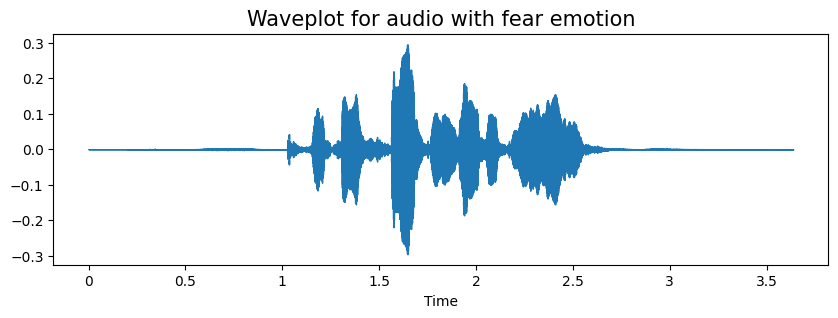

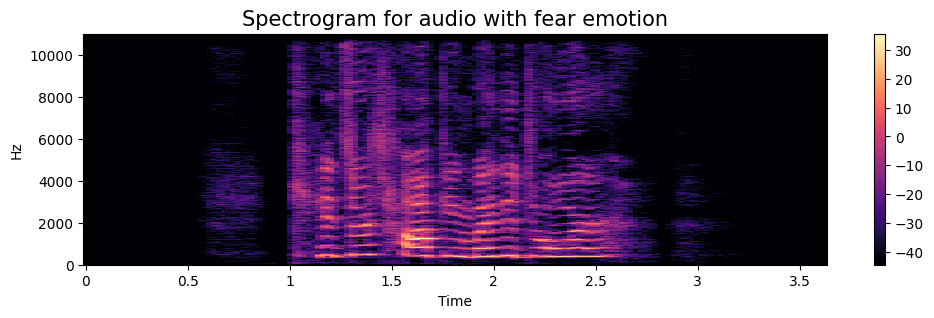

In [7]:
emotion='fear'
path = np.array(RAV_df.path[RAV_df.emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
ipd.Audio(path)

### 4. Data Augmentation :

In [8]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate = rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(RAV_df.path)[1]
data, sample_rate = librosa.load(path)

#### 4.1 Simple Audio:

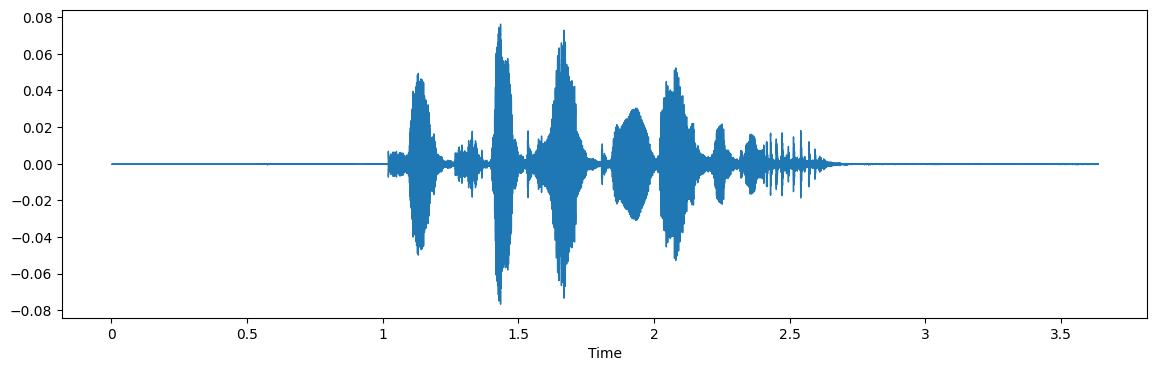

In [9]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
ipd.Audio(path)

#### 4.2 Noise Injection :

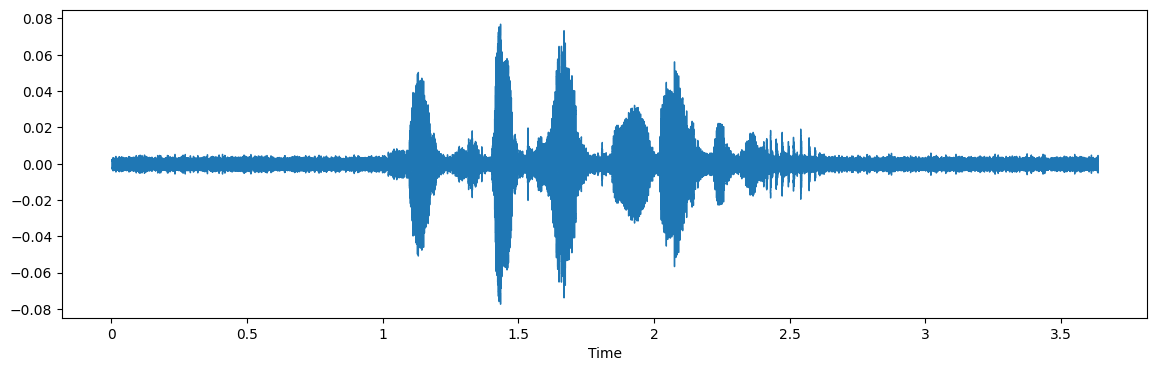

In [10]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.3 Stretching :

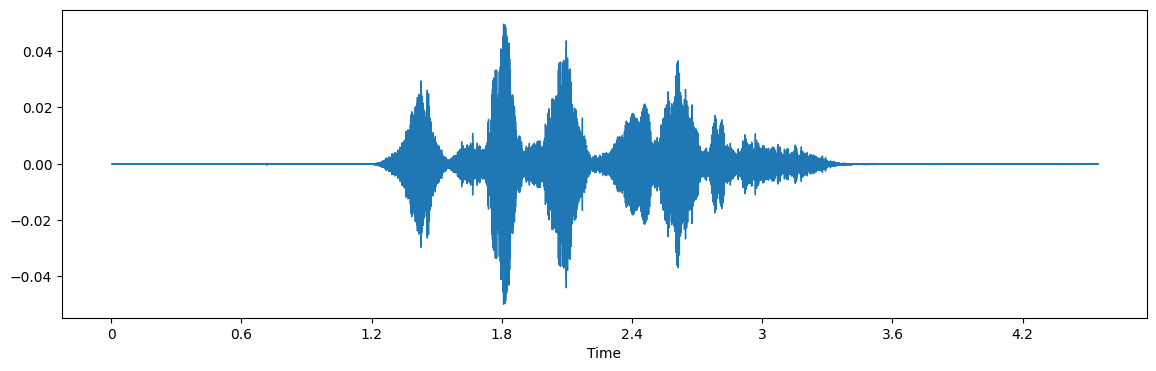

In [11]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.4 Shifting :

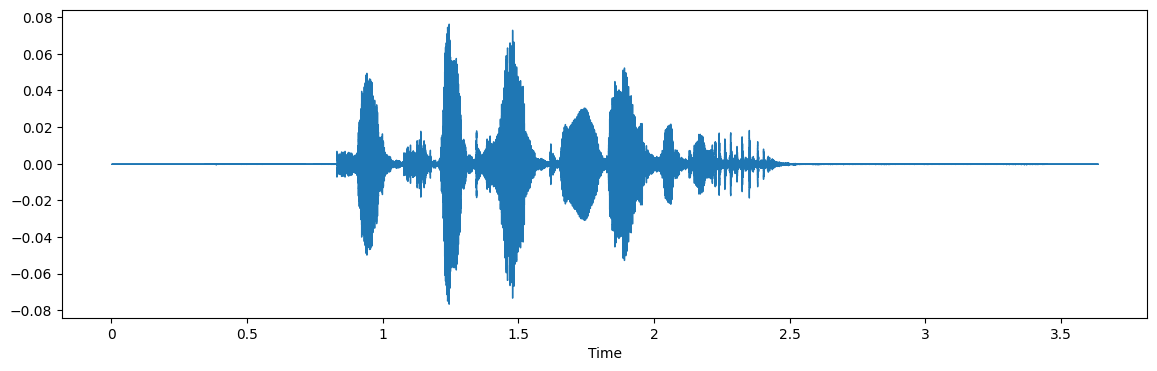

In [12]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

#### 4.5 Pitch :

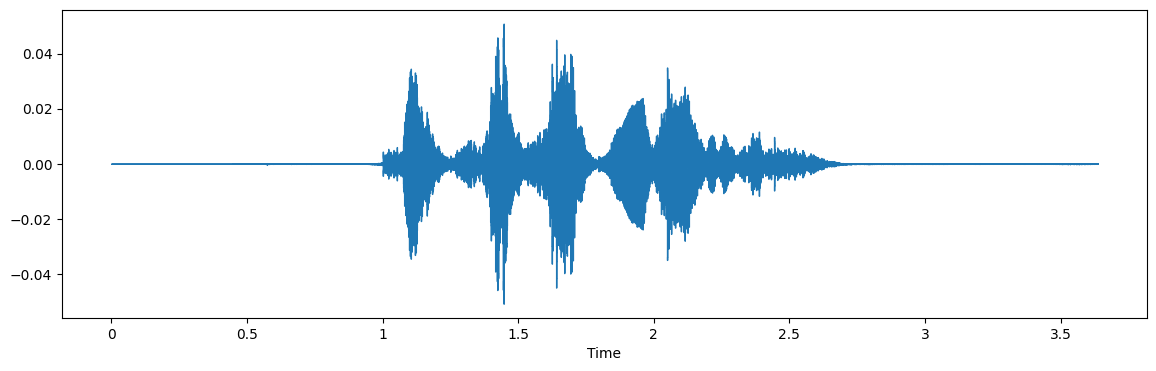

In [13]:
x = pitch(data,sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
ipd.Audio(x, rate=sample_rate)

### 5 Feature Extraction :

In [14]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

### 6. Data Preperation

In [15]:
X, Y = [], []
for path, emotion in zip(RAV_df.path, RAV_df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [16]:
len(X), len(Y), RAV_df.path.shape

(4320, 4320, (1440,))

In [17]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)

In [18]:
display(Features.head())
display(Features.describe())

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.237382,0.682273,0.670519,0.614793,0.579039,0.566803,0.637206,0.667451,0.663883,0.669903,...,0.000234,0.000235,0.000138,0.000128,0.000299,0.000360,0.000275,0.000173,2.896729e-05,surprise
1,0.310456,0.714076,0.728171,0.707522,0.677155,0.702904,0.712388,0.692279,0.667254,0.683226,...,0.000572,0.000570,0.000478,0.000464,0.000641,0.000676,0.000617,0.000532,3.788525e-04,surprise
2,0.185641,0.701613,0.669992,0.646490,0.569480,0.522187,0.620171,0.694169,0.706142,0.679081,...,0.000047,0.000049,0.000054,0.000048,0.000024,0.000053,0.000074,0.000031,2.444069e-06,surprise
3,0.256113,0.621621,0.580278,0.598515,0.628296,0.598015,0.597272,0.650352,0.698635,0.681863,...,0.000018,0.000016,0.000013,0.000012,0.000007,0.000008,0.000008,0.000005,5.802853e-07,neutral
4,0.309507,0.681936,0.681384,0.723257,0.738541,0.715945,0.661446,0.694755,0.735224,0.721342,...,0.000132,0.000131,0.000130,0.000130,0.000130,0.000125,0.000120,0.000124,1.207863e-04,neutral


,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
count,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,4320.000000,...,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03,4.320000e+03
mean,0.210899,0.628188,0.631443,0.635939,0.646011,0.635195,0.606466,0.600925,0.619953,0.637280,...,1.729453e-03,1.742006e-03,1.779090e-03,1.818948e-03,1.870689e-03,1.905318e-03,1.899602e-03,1.854893e-03,1.363452e-03,7.279992e-04
std,0.068747,0.088165,0.097650,0.100457,0.102259,0.104812,0.091434,0.079012,0.080529,0.079327,...,6.137391e-03,6.191361e-03,6.324720e-03,6.600442e-03,6.913250e-03,6.911782e-03,6.709500e-03,6.354194e-03,5.316298e-03,4.276972e-03
min,0.060091,0.339261,0.287325,0.274444,0.261164,0.263645,0.269483,0.262952,0.242572,0.269638,...,2.135293e-08,1.692828e-08,2.129181e-08,2.400353e-08,2.899570e-08,2.325147e-08,6.041341e-08,7.742906e-08,3.496952e-08,2.159540e-09
25%,0.154699,0.569546,0.565666,0.565600,0.576101,0.565657,0.550781,0.553383,0.568210,0.586247,...,2.947921e-05,2.959642e-05,3.059478e-05,3.202946e-05,3.531418e-05,3.471987e-05,3.448347e-05,3.360516e-05,1.973107e-05,1.981131e-06
50%,0.202277,0.632302,0.636570,0.641995,0.652901,0.641655,0.614997,0.609296,0.626195,0.643353,...,1.692231e-04,1.717610e-04,1.729905e-04,1.848143e-04,1.899027e-04,1.857865e-04,1.914825e-04,1.865082e-04,1.163039e-04,1.484992e-05
75%,0.267437,0.691734,0.701191,0.708493,0.720532,0.709543,0.671588,0.655700,0.678198,0.693794,...,8.867496e-04,8.836491e-04,9.349039e-04,9.055756e-04,9.237624e-04,9.260404e-04,9.379941e-04,9.455185e-04,6.089732e-04,1.145064e-04
max,0.401204,0.860744,0.878730,0.890050,0.905715,0.900080,0.892214,0.813966,0.849083,0.868190,...,1.064655e-01,1.009477e-01,1.213932e-01,1.448232e-01,1.676426e-01,1.543559e-01,1.303758e-01,1.019984e-01,9.280708e-02,8.560010e-02


In [19]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [20]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 7), (1080, 162), (1080, 7))

In [23]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 7), (1080, 162, 1), (1080, 7))

### 7. Modelling :

In [24]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=16, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 162, 256)       │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 81, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 81, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 41, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 41, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 21, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 21, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 352)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │         5,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           119 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,567 (869.40 KB)

 Trainable params: 222,567 (869.40 KB)

 Non-trainable params: 0 (0.00 B)

### 8. Training :

In [25]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.2399 - loss: 1.8906 - val_accuracy: 0.2935 - val_loss: 1.7626 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 123ms/step - accuracy: 0.2632 - loss: 1.8255 - val_accuracy: 0.3130 - val_loss: 1.7361 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.2868 - loss: 1.7929 - val_accuracy: 0.3750 - val_loss: 1.6974 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.3305 - loss: 1.7184 - val_accuracy: 0.3574 - val_loss: 1.6334 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.3399 - loss: 1.6725 - val_accuracy: 0.3935 - val_loss: 1.5959 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.3642 - loss: 1.6434 - val_accuracy: 0.4167 - val_loss: 1.6321 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.3738 - loss: 1.6270 

### 9. Evaluation :

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6175 - loss: 1.1433
Accuracy of our model on test data :  61.38888597488403 %


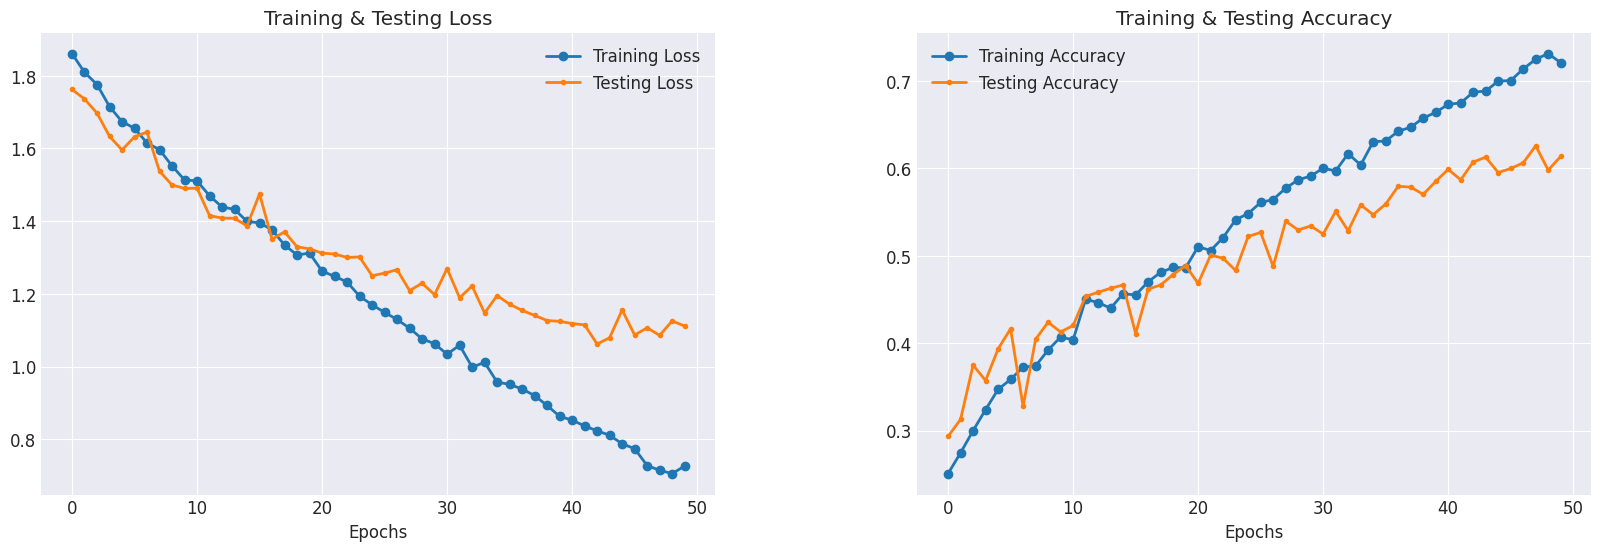

In [26]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

plt.style.use('seaborn-darkgrid')
plt.rcParams.update({'font.size': 12})
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=2)
ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=2)
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=2)
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=2)
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.subplots_adjust(wspace=0.3)
plt.show()

In [27]:
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [28]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

display(df.head())

,Predicted Labels,Actual Labels
0,fear,fear
1,neutral,neutral
2,sad,sad
3,surprise,neutral
4,angry,fear


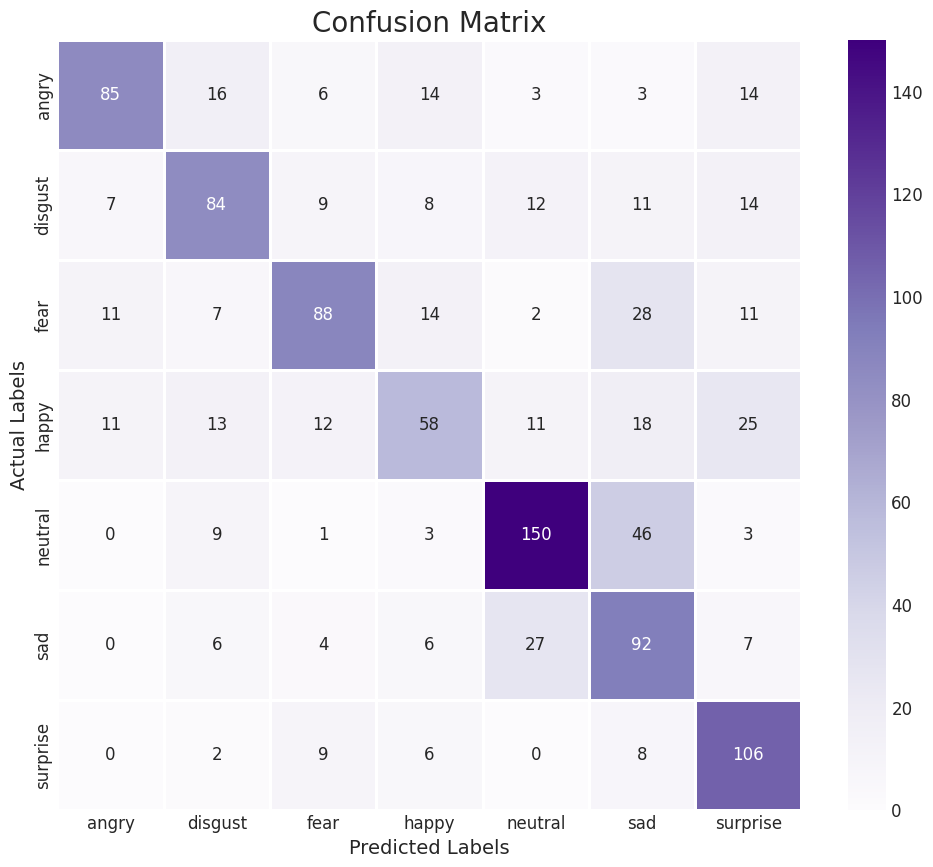

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [30]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.60      0.67       141
     disgust       0.61      0.58      0.60       145
        fear       0.68      0.55      0.61       161
       happy       0.53      0.39      0.45       148
     neutral       0.73      0.71      0.72       212
         sad       0.45      0.65      0.53       142
    surprise       0.59      0.81      0.68       131

    accuracy                           0.61      1080
   macro avg       0.62      0.61      0.61      1080
weighted avg       0.63      0.61      0.61      1080



In [31]:
model.save('emotion_model.keras')